# CNN: Image classification

Convolutional Neural Networks (CNNs) are specifically designed to process data with a grid-like topology, such as images.

They are composed of layers designed for handling grid-like data, including convolutional layers, pooling layers, and fully connected layers.

Components:

- Input: The input to the CNN is an image

- Hidden Layers:

    - Convolutional Layers: These layers apply convolution operations to the input image to extract features from the input data. They learn to detect patterns, edges, and textures. The use of Rectified Linear Unit (ReLU) activation functions allows the network to capture and enhance important features within the image.

    - Pooling Layers: After convolution, pooling layers downsample the spatial dimensions, reducing the computational load and retaining important features.

- Classification:

    - Flatten Layer: After feature extraction, the Flatten layer reshapes the data into a one-dimensional vector.

    - Fully Connected Layers: These layers take the flattened data and perform further processing, learning complex patterns and relationships.

    - Softmax Activation: At the end of the network, an activation function is typically applied to generate probability distributions over different classes. This allows the network to make predictions and classify the input image into one of several predefined categories.



<div style="text-align:center;">
<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png"  width="50%" height="50%">
</div>


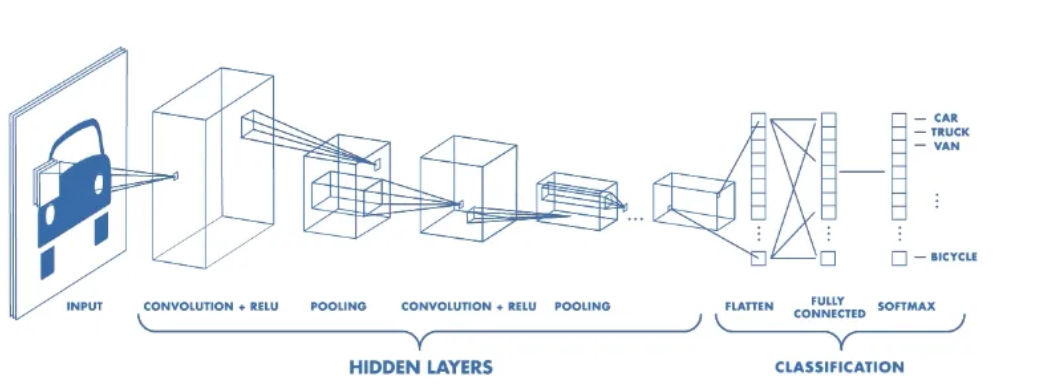

## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
jupyter_notebook.ipynb
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [9]:
import pathlib

# Path to the extracted flower_photos directory
data_dir = pathlib.Path('./flower_photos')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

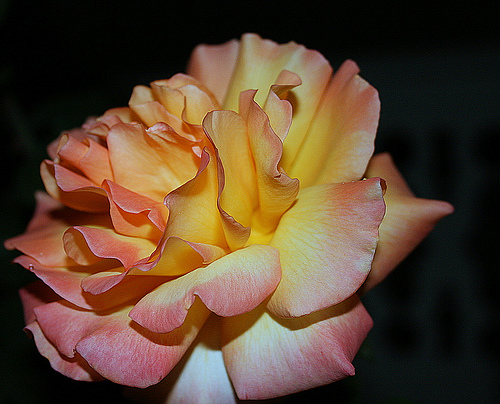

In [13]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[100]))

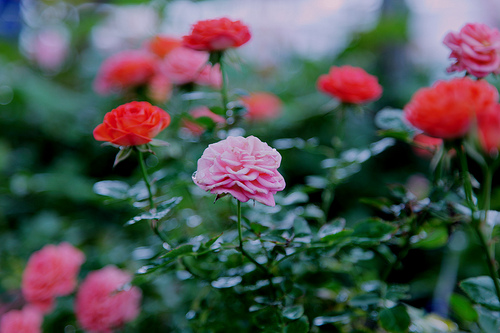

In [14]:
PIL.Image.open(str(roses[1]))

**Question** : Add some tulips:

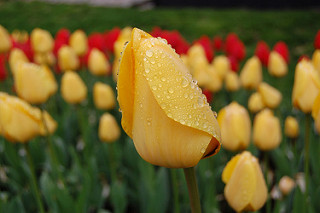

In [17]:
# First tulip
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[100]))

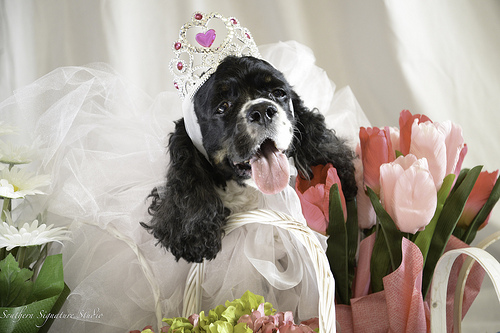

In [30]:
# Random tulip
n = np.random.randint(len(tulips))
PIL.Image.open(str(tulips[n]))

### Create a dataset

Define some parameters for the loader:

In [31]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [33]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [34]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

2024-10-08 11:22:19.640999: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


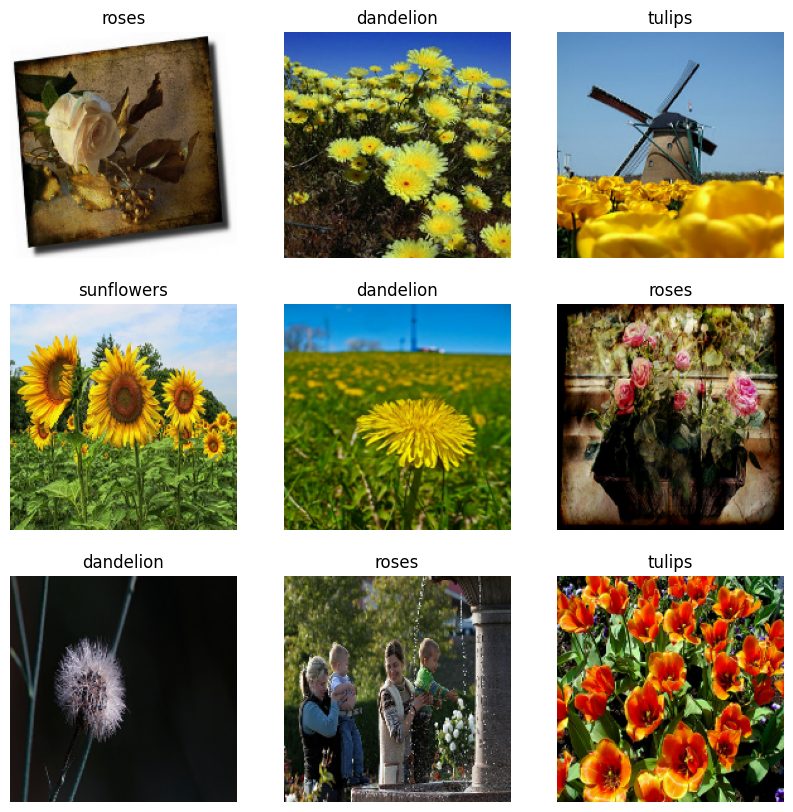

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.


In [36]:
AUTOTUNE = tf.data.AUTOTUNE #ensure that data loading and preprocessing are as efficient as possible

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range :

In [37]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [38]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds)) #fetch the first batch of normalized data and their corresponding labels
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99970955


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

## Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [39]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
%%time
# Train model
epochs=10 # number of times a complete dataset is passed
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 342ms/step - accuracy: 0.3206 - loss: 1.6164 - val_accuracy: 0.5559 - val_loss: 1.1017
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 324ms/step - accuracy: 0.5965 - loss: 1.0300 - val_accuracy: 0.5981 - val_loss: 1.0036
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 315ms/step - accuracy: 0.6666 - loss: 0.8486 - val_accuracy: 0.6499 - val_loss: 0.8990
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 329ms/step - accuracy: 0.7126 - loss: 0.7462 - val_accuracy: 0.6335 - val_loss: 0.9440
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 334ms/step - accuracy: 0.8075 - loss: 0.5338 - val_accuracy: 0.6349 - val_loss: 1.0028
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 326ms/step - accuracy: 0.8552 - loss: 0.4184 - val_accuracy: 0.6158 - val_loss: 1.0783
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 361ms/step - accuracy: 0.9213 - loss: 0.2612 - val_accuracy: 0.6349 - val_loss: 1.3612
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 331ms/step - accuracy: 0.9685 - loss: 0.1238 - val_accu

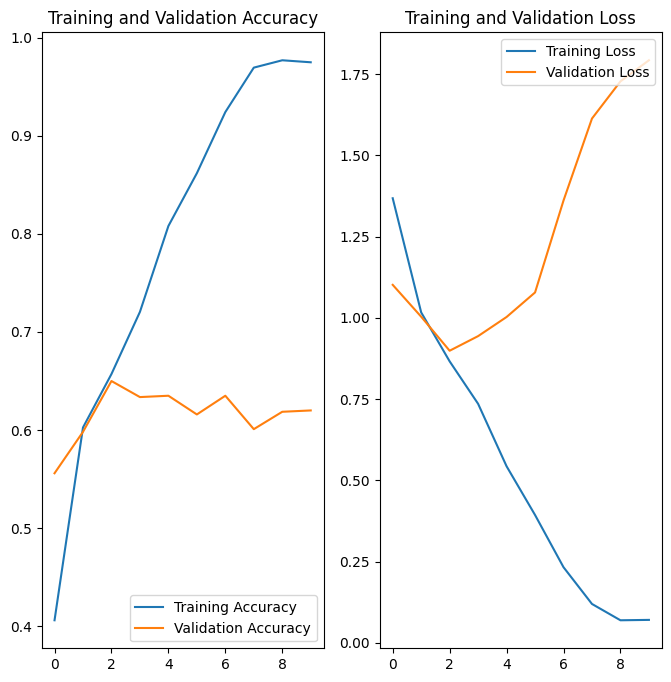

In [43]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.


In [44]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

2024-10-08 11:38:19.027265: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


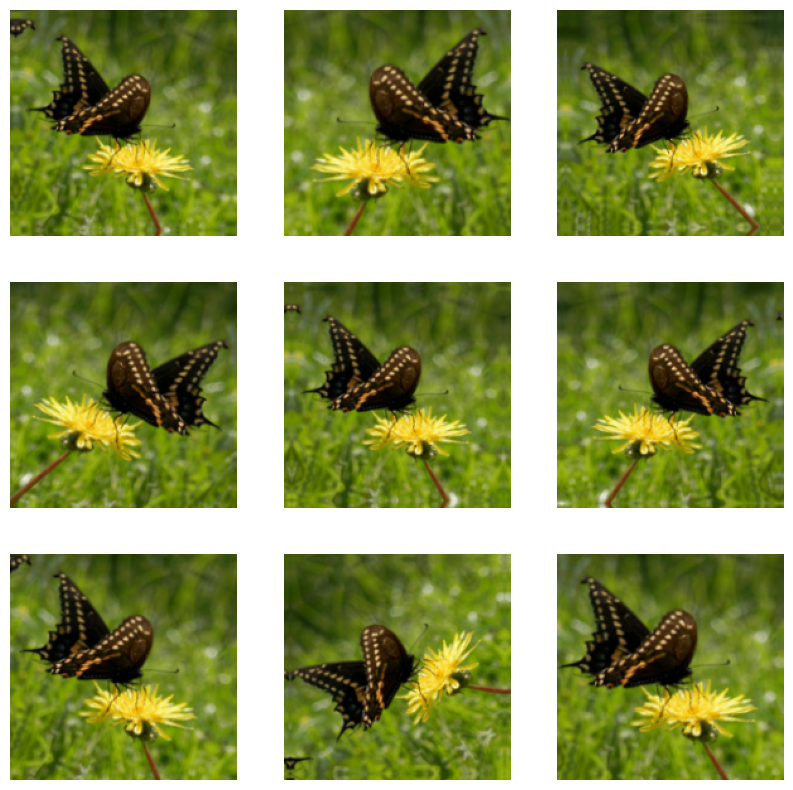

In [45]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.


In [46]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
%%time
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 355ms/step - accuracy: 0.3389 - loss: 1.5214 - val_accuracy: 0.5490 - val_loss: 1.1235
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 351ms/step - accuracy: 0.5772 - loss: 1.0933 - val_accuracy: 0.6131 - val_loss: 0.9663
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 383ms/step - accuracy: 0.6297 - loss: 0.9709 - val_accuracy: 0.6131 - val_loss: 0.9275
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 348ms/step - accuracy: 0.6755 - loss: 0.8750 - val_accuracy: 0.6485 - val_loss: 0.8948
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.6644 - loss: 0.8651 - val_accuracy: 0.6553 - val_loss: 0.8581
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 392ms/step - accuracy: 0.7022 - loss: 0.7642 - val_accuracy: 0.7057 - val_loss: 0.7801
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 361ms/step - accuracy: 0.7123 - loss: 0.7432 - val_accuracy: 0.7221 - val_loss: 0.7546
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 377ms/step - accuracy: 0.7453 - loss: 0.6754 - val_accu

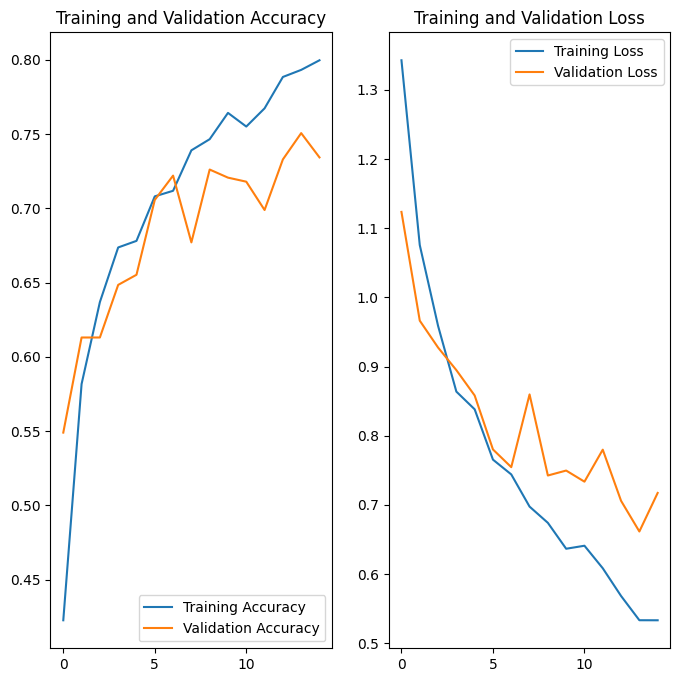

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

<div style="text-align:center;">
<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"  width="25%" height="25%">
</div>


In [53]:
sunflower_path = pathlib.Path('./Red_sunflower.jpg')

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to sunflowers with a 98.18 percent confidence.


**Question:** Faire des nouveaux prediction sur de nouvelles photos du net

In [54]:
tulip_path =  pathlib.Path('./White_tulip.jpeg')

img = tf.keras.utils.load_img(
    tulip_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to tulips with a 80.22 percent confidence.


In [55]:
rose_path = sunflower_path = pathlib.Path('./Blue_rose.jpg')

img = tf.keras.utils.load_img(
    rose_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
This image most likely belongs to roses with a 98.38 percent confidence.


**Question:** Modifeir les hyperparamètres de la création du modèle pour essayer d'améliorer les performances

In [56]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     3,965,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,063,909 (15.50 MB)

 Trainable params: 4,063,909 (15.50 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
%%time
epochs = 16
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/16
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.3508 - loss: 1.4663 - val_accuracy: 0.5450 - val_loss: 1.0828
Epoch 2/16
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 384ms/step - accuracy: 0.5824 - loss: 1.0533 - val_accuracy: 0.6049 - val_loss: 0.9856
Epoch 3/16
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 432ms/step - accuracy: 0.6134 - loss: 0.9700 - val_accuracy: 0.6362 - val_loss: 0.8664
Epoch 4/16
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 438ms/step - accuracy: 0.6589 - loss: 0.8790 - val_accuracy: 0.6608 - val_loss: 0.8772
Epoch 5/16
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.6867 - loss: 0.8113 - val_accuracy: 0.6921 - val_loss: 0.8168
Epoch 6/16
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 383ms/step - accuracy: 0.7004 - loss: 0.7801 - val_accuracy: 0.6975 - val_loss: 0.7760
Epoch 7/16
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 447ms/step - accuracy: 0.7408 - loss: 0.7040 - val_accuracy: 0.6921 - val_loss: 0.7962
Epoch 8/16
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 409ms/step - accuracy: 0.7148 - loss: 0.7384 - val_accu

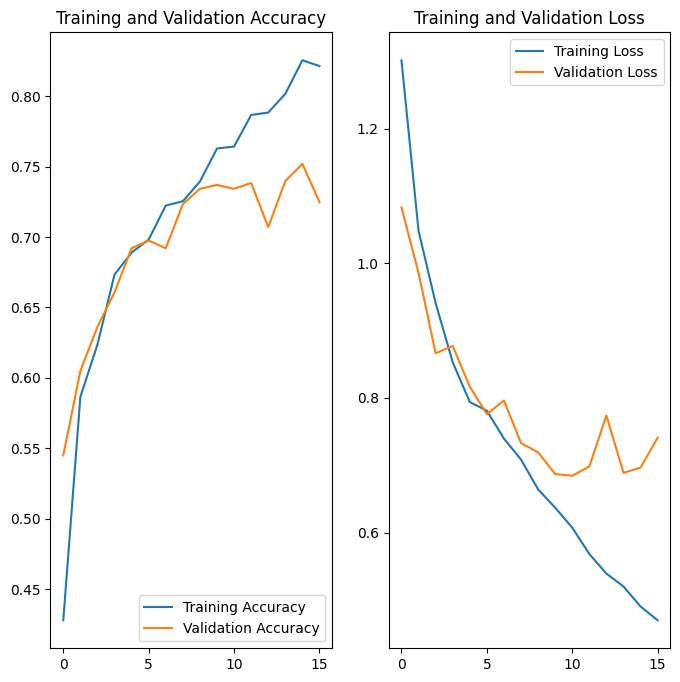

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
from tensorflow.keras import regularizers

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.15),
  layers.Flatten(),
  layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.Dense(num_classes, name="outputs")
])



In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,965,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,063,909 (15.50 MB)

 Trainable params: 4,063,909 (15.50 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
%%time
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.3147 - loss: 2.8939 - val_accuracy: 0.5545 - val_loss: 1.2382
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 426ms/step - accuracy: 0.5432 - loss: 1.2463 - val_accuracy: 0.5695 - val_loss: 1.2056
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 413ms/step - accuracy: 0.6028 - loss: 1.1458 - val_accuracy: 0.6240 - val_loss: 1.0729
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 426ms/step - accuracy: 0.6470 - loss: 1.0599 - val_accuracy: 0.6035 - val_loss: 1.2452
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 448ms/step - accuracy: 0.6513 - loss: 1.0424 - val_accuracy: 0.6553 - val_loss: 1.0057
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 412ms/step - accuracy: 0.6600 - loss: 0.9914 - val_accuracy: 0.6771 - val_loss: 0.9670
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 437ms/step - accuracy: 0.6834 - loss: 0.9505 - val_accuracy: 0.6853 - val_loss: 0.9162
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 415ms/step - accuracy: 0.6952 - loss: 0.9276 - val_accu

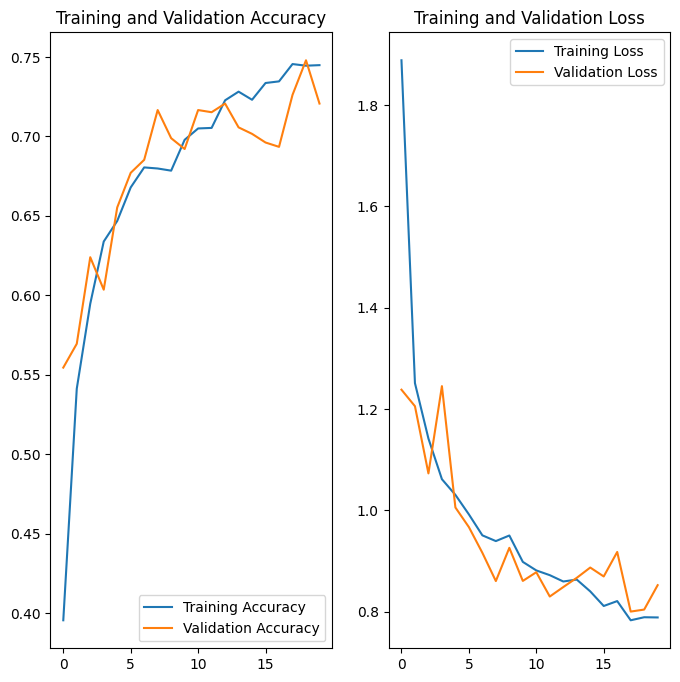

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()